# Figure 3
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [18]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats
import cartopy as cart

Data locations

In [19]:
loc_shp = "../Data/CountryShapefile/"
loc_pop = "../Data/Population/"
loc_panel = "../Data/Panel/"
loc_damages_processed = "../Data/Damages/Processed/"

Map helper function

In [20]:
def add_country_geometries(input_vals,iso_vals,iso_plot,shapefile,shapefile_iso_name,cbar):
    for i in iso_plot:
        if i in iso_vals:
            val = input_vals.loc[i].values
            if (~np.isnan(val)):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
            else:
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
def add_attr_geometries(input_vals,iso_vals,iso_plot,shapefile,shapefile_iso_name,cbar):
    for i in iso_plot:
        if i in iso_vals:
            val = input_vals.loc[i].values
            if (~np.isnan(val))&(np.abs(val)!=0):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
            elif (~np.isnan(val))&(np.abs(val)==0):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
            elif (np.isnan(val)):
                ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shapefile.loc[shapefile[shapefile_iso_name].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)

Shapefile

In [21]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values
num_shp = shp.UN.values

#### Analysis/plotting

2 x 3 maps

In [22]:
accounting_loop = ["territorial","consumption","territorial"]
y1_loop = [1990,1990,1960]
y2 = 2014
#titles = ["Net damages","Net damages","Net damages"]
damagefunc_loop = ["BHMSR","BHMSR","BHMSR"]
ch = ["Consumption vs. territorial","1960-2014 vs. 1990-2014"]

<xarray.DataArray 'attributable_losses' (iso_attr: 6)>
array([  1.52868491,  -9.23637906, -15.40752383,  25.92679977,
        16.83499844,  16.55357197])
Coordinates:
  * iso_attr  (iso_attr) object 'USA' 'CHN' 'RUS' 'FRA' 'DEU' 'GBR'


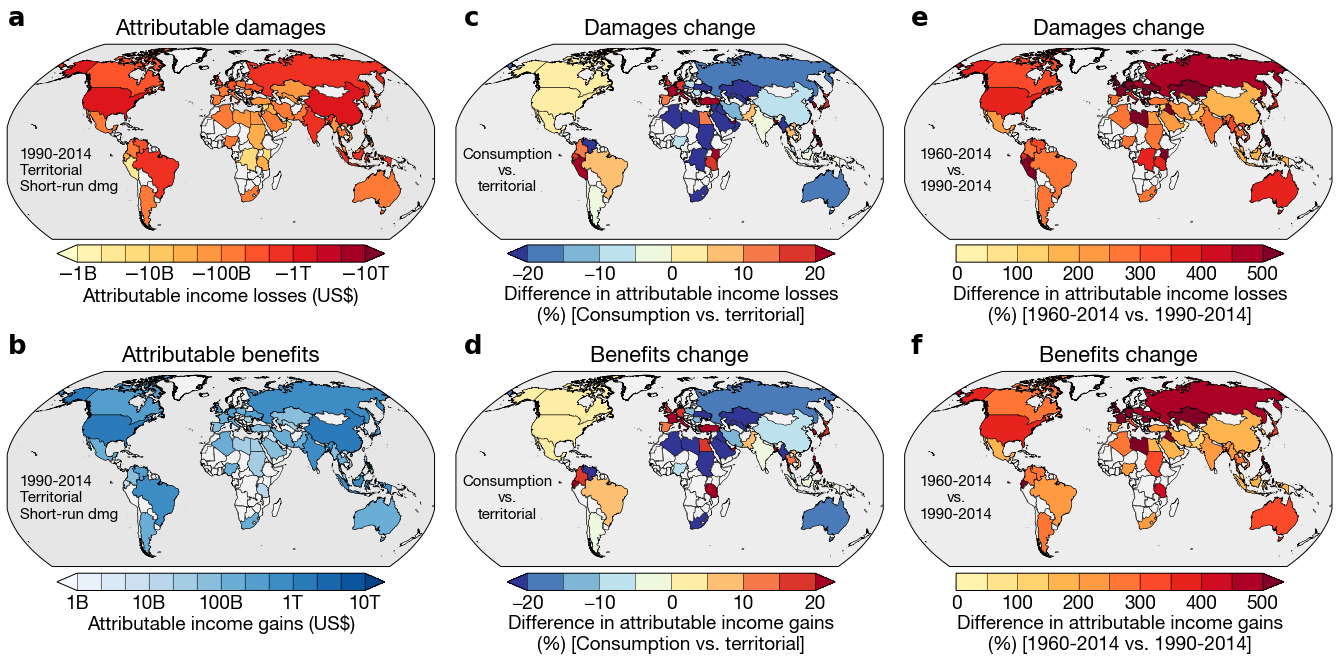

In [23]:
fig = plt.figure(figsize=(23,12))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 19.0

gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.23,wspace=0.05,hspace=0.3)

tfs = 22

# colorbar positions
left = [0.13,0.402,0.673]
bottom1 = 0.615
bottom2 = 0.235
width = 0.198
height = 0.02
tks = [1e9,1e10,1e11,1e12,1e13]
lbs1 = [r"$\rm{-}$1B",r"$\rm{-}$10B",r"$\rm{-}$100B",\
        r"$\rm{-}$1T",r"$\rm{-}$10T"]
lbs2 = ["1B","10B","100B","1T","10T"]

# details for maps of damages changes
change_ext = ["both","max"]
change_min = [-20,0]
change_max = [20,500]
change_ncol = [9,11]
change_maps = ["RdYlBu_r","YlOrRd"]


# loop through accounting/y1/etc.
for j in np.arange(0,len(accounting_loop),1):
    if j == 0:
        rcParams["axes.linewidth"] = 1
        rcParams['xtick.major.size'] = 4
        rcParams['xtick.major.width'] = 1
        rcParams['ytick.major.size'] = 4
        rcParams['ytick.major.width'] = 1
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")*-1
        
        # losses
        ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
        vmin = 1e9
        vmax = 1e13
        ncol = 13
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])
        
        # add colors/geoms
        add_attr_geometries(attr_losses,iso_shp,attr_losses.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable damages",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs1)
        cb.set_label("Attributable income losses (US$)",labelpad=2)
        
        
        # benefits
        ax = plt.subplot(gs1[1,0],projection=ccrs.Robinson())
        
        ncol = 14
        bounds = np.linspace(vmin,vmax,ncol)
        cols = plt.get_cmap('Blues')(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-2])
        cm.set_over(cols[-2])
        cm.set_under(cols[0])
        norm = colors.SymLogNorm(linthresh=1e3,vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.9,0.9,0.9])

        # add colors/geoms
        add_attr_geometries(attr_benefits,iso_shp,attr_benefits.iso_attr.values,shp,"ISO3",cbar)
        
        plt.title("Attributable benefits",fontsize=tfs,pad=10)
        
        if damagefunc_loop[j] == "BHMSR":
            funcstr = "Short-run dmg"
        elif damagefunc_loop[j] == "BHMLR":
            funcstr = "Long-run dmg"
        st = str(y1_loop[j])+"-"+str(y2)+"\n"+accounting_loop[j].title()+"\n"+funcstr
        plt.text(0.03,0.25,st,ha="left",fontsize=15,
                transform=ax.transAxes)
        
        # colorbar
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend="both",ticks=tks,extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.ax.set_xticklabels(lbs2)
        cb.set_label("Attributable income gains (US$)",labelpad=2)
        
        
    else:
        # damages and benefits change 
        
        fname_str = damagefunc_loop[j]+"_"+accounting_loop[j]+"_shares"+str(y1_loop[j])+"-"+str(y2)+"_"+str(y1_loop[j])+"-"+str(y2)
        fname_str_orig = damagefunc_loop[0]+"_"+accounting_loop[0]+"_shares"+str(y1_loop[0])+"-"+str(y2)+"_"+str(y1_loop[0])+"-"+str(y2)
        damages_processed = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str+".nc")
        attr_losses = damages_processed.attributable_losses.sum(dim="time")
        attr_benefits = damages_processed.attributable_benefits.sum(dim="time")
        damages_processed_orig = xr.open_dataset(loc_damages_processed+"global_attributable_benefits_losses_"+fname_str_orig+".nc")
        attr_losses_orig = damages_processed_orig.attributable_losses.sum(dim="time")
        attr_benefits_orig = damages_processed_orig.attributable_benefits.sum(dim="time")
        attr_damages_change1 = 100*(attr_losses - attr_losses_orig)/attr_losses_orig
        attr_benefits_change1 = 100*(attr_benefits - attr_benefits_orig)/attr_benefits_orig
        attr_damages_change = attr_damages_change1.where(~np.isinf(np.abs(attr_damages_change1)),0.0)
        attr_benefits_change = attr_benefits_change1.where(~np.isinf(np.abs(attr_benefits_change1)),0.0)
        if accounting_loop[j]=="consumption":
            benefits_chng = attr_benefits_change
            loss_chng = attr_damages_change
            print(loss_chng.loc[["USA","CHN","RUS","FRA","DEU","GBR"]])
            
        # damages change
        ax = plt.subplot(gs1[0,j],projection=ccrs.Robinson())
        
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        # colorbar
        vmin = change_min[j-1]
        vmax = change_max[j-1]
        ncol = change_ncol[j-1]
        bounds = np.linspace(vmin,vmax,ncol)

        cols = plt.get_cmap(change_maps[j-1])(np.linspace(0,1,len(bounds)+1))
        cm = colors.ListedColormap(cols[1:-1])
        cm.set_over(cols[-1])
        cm.set_under(cols[0])
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)   
        
        add_attr_geometries(attr_damages_change,iso_shp,attr_damages_change.iso_attr.values,shp,"ISO3",cbar)
        
        
        plt.title("Damages change",fontsize=tfs,pad=10)
        
        if j == 1:
            st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        elif j == 2:
            st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        plt.text(0.12,0.25,st,ha="center",fontsize=15,
                transform=ax.transAxes)
    
        cbar_ax = fig.add_axes([left[j], bottom1, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend=change_ext[j-1],extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income losses"+"\n"+"(%) ["+ch[j-1]+"]",
                    labelpad=2)
        
        
        # benefits change
        
        ax = plt.subplot(gs1[1,j],projection=ccrs.Robinson())
        plt.setp(ax.spines.values(), linewidth=1)
        ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])
        
        add_attr_geometries(attr_benefits_change,iso_shp,attr_benefits_change.iso_attr.values,shp,"ISO3",cbar)
            
        plt.title("Benefits change",fontsize=tfs,pad=10)
        
        if j == 1:
            st = "Consumption"+"\n"+"vs."+"\n"+"territorial"
        elif j == 2:
            st = "1960-2014"+"\n"+"vs."+"\n"+"1990-2014"
        plt.text(0.12,0.25,st,ha="center",fontsize=15,
                transform=ax.transAxes)
        
        cbar_ax = fig.add_axes([left[j], bottom2, width, height])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,
                          extend=change_ext[j-1],extendfrac=0.07)
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Difference in attributable income gains"+"\n"+"(%) ["+ch[j-1]+"]",
                    labelpad=2)
        
        
xx1 = 0.1
xx2 = 0.375
xx3 = 0.645
yy1 = 0.889
yy2 = 0.51
plt.figtext(xx1,yy1,r'$\bf{a}$',fontsize=26)
plt.figtext(xx2,yy1,r'$\bf{c}$',fontsize=26)
plt.figtext(xx3,yy1,r'$\bf{e}$',fontsize=26)

plt.figtext(xx1,yy2,r'$\bf{b}$',fontsize=26)
plt.figtext(xx2,yy2,r'$\bf{d}$',fontsize=26)
plt.figtext(xx3,yy2,r'$\bf{f}$',fontsize=26)


plt.savefig("../Fig3.png")

plt.show()

In [24]:
len(attr_losses_orig)

174

In [25]:
len(attr_losses_orig[attr_losses_orig.values!=0])/174.

0.3160919540229885

In [26]:
100*attr_losses_orig.sortby(attr_losses_orig)[0:5].sum()/attr_losses_orig.sum()

<xarray.DataArray 'attributable_losses' ()>
array(52.48197258)

In [27]:
100*attr_benefits_orig.sortby(attr_benefits_orig,ascending=False)[0:5].sum()/attr_benefits_orig.sum()

<xarray.DataArray 'attributable_benefits' ()>
array(55.60571016)

In [28]:
attr_losses_orig.loc[["USA","CHN"]]

<xarray.DataArray 'attributable_losses' (iso_attr: 2)>
array([-1.90811670e+12, -1.82902026e+12])
Coordinates:
  * iso_attr  (iso_attr) object 'USA' 'CHN'

In [29]:
attr_losses_orig.loc[["RUS","IND","BRA"]]

<xarray.DataArray 'attributable_losses' (iso_attr: 3)>
array([-9.86019736e+11, -8.09420168e+11, -5.27991491e+11])
Coordinates:
  * iso_attr  (iso_attr) object 'RUS' 'IND' 'BRA'

In [30]:
attr_benefits_orig.loc[["USA","CHN"]]

<xarray.DataArray 'attributable_benefits' (iso_attr: 2)>
array([1.93836954e+12, 1.81534875e+12])
Coordinates:
  * iso_attr  (iso_attr) object 'USA' 'CHN'

In [31]:
attr_losses_orig.loc[["USA","BRA","RUS","CHN","IND"]].sum()

<xarray.DataArray 'attributable_losses' ()>
array(-6.06056836e+12)

In [32]:
loc_emissions = "../Data/Emissions/"
y1_emissions = 1990
y2_emissions = 2014
emissions_terr = xr.open_dataset(loc_emissions+"FAIR_GHGEmissions_Input_Territorial_"+str(y1_emissions)+"-"+str(y2_emissions)+".nc").emissions
co2_emissions_terr = emissions_terr.loc[:,:,["CO2-fossil","CO2-landuse"]].sum(dim="species").mean(dim="time")

dataframe

In [33]:
df = pd.DataFrame({"iso":co2_emissions_terr.iso.values,
                   "emissions":co2_emissions_terr.values*1000,
                  "losses":attr_losses_orig.values}).sort_values(by="emissions")

In [34]:
print(df.to_string())

     iso    emissions        losses
115  NZL    -1.950112  0.000000e+00
85   LIE    -0.001822  0.000000e+00
107  PSE     0.000000  0.000000e+00
103  IMN     0.000000  0.000000e+00
169  VAT     0.000000  0.000000e+00
170  SJM     0.000000  0.000000e+00
106  MCO     0.000000  0.000000e+00
171  GGY     0.000000  0.000000e+00
172  JEY     0.000000  0.000000e+00
132  LSO     0.000299  0.000000e+00
53   GRL     0.000403  0.000000e+00
101  AND     0.000944  0.000000e+00
167  ESH     0.002171  0.000000e+00
127  PRI     0.025482  0.000000e+00
161  SWZ     0.100129  0.000000e+00
102  GIB     0.109278  0.000000e+00
34   DJI     0.122633  0.000000e+00
108  MNE     0.197410  0.000000e+00
105  MAC     0.346776  0.000000e+00
41   ERI     0.440933  0.000000e+00
129  RWA     0.488190  0.000000e+00
49   GMB     0.514617  0.000000e+00
24   BTN     0.631834  0.000000e+00
63   ISL     0.717537  0.000000e+00
21   BDI     0.744931  0.000000e+00
2    ALB     0.768551  0.000000e+00
113  SUR     0.929098  0.000